In [0]:
# 고용량 램 사용

a = []
while(1):
    a.append('1')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install sunpy

     |████████████████████████████████| 6.8MB 2.5MB/s 
     |████████████████████████████████| 1.2MB 32.0MB/s 
     |████████████████████████████████| 256kB 43.2MB/s 
     |████████████████████████████████| 153kB 45.5MB/s 
  Created wheel for parfive: filename=parfive-1.0.0-cp36-none-any.whl size=12218 sha256=15590905253320581e0f5bc93e859e66ff5479914da2c9aa0ab5731bf8b81475
  Stored in directory: /root/.cache/pip/wheels/b0/f6/1e/59105ec530148b9e1230d21493efef1c7def128ebfb34a7782
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=fd90673b1748997fcc708559085693ad377a1d6d0eaffbb88b3a97413f1ad5c7
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built parfive idna-ssl


In [1]:
import warnings
import sunpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from sunpy.map import Map
#from sunpy.io import fits
from sunpy.instr.aia import aiaprep
import os
get_ipython().run_line_magic('matplotlib', 'inline')
from imageio import imsave
from skimage import data
from skimage.transform import resize
import math

warnings.filterwarnings('ignore')

In [2]:
# AIA fits 파일 있는 폴더 경로 설정

file_list = os.listdir('/content/drive/My Drive/aia_2011_1hr_real')
file_list.sort()
file_list = ['/content/drive/My Drive/aia_2011_1hr_real//' + item for item in file_list]

In [ ]:
# 1. AIA를 numpy array로 읽고, 노출 시간으로 나눠준 후, 태양 내부에만 해당하는 픽셀값 골라서, 그 중 min max median, 그리고 datetime 구하기 (그래프 그리기 위해)

isize = 4096 # AIA 파일의 크기
X = np.arange(isize)[:, None]
Y = np.arange(isize)[None :]
XY = np.sqrt((X-isize/2.)**2. + (Y-isize/2.)**2.)

def run(i):
    file = fits.open(file_list[i]) # 메모리 문제 때문에 다시 닫기 위해서 close 기능 있는 astropy로 파일 읽기 (sunpy는 read)
    M = aiaprep(Map(file_list[i]))
    file.close()
    meta = M.meta
    rsun = meta['R_SUN'] # prep 했을 때 두 가지 rsun이 있는데, prep 안했을 때 rsun이 픽셀 단위이므로 prep 했을 때 rsun도 마찬가지임
    exptime = meta['EXPTIME']
    data = M.data / exptime
    Z = np.where(XY < rsun)
    aia_max = np.max(data[Z])
    aia_min = np.min(data[Z])
    aia_median = np.median(data[Z])
    ratio = 10./aia_median
    
    datetime = meta['T_REC'].replace('T',' ')
    
    # median 값을 임의의 값인 10으로 통일시켜서 degradation 보정 (=background의 밝기를 동일하게)
    
    data_new = data * ratio
    data_new = np.log10((data_new + 1.).clip(1., 100.)) * (255./2.)

    return (aia_max, aia_min, aia_median, datetime) # 튜플 형식, 잠시 median, datetime은 안 받는걸로

# 태양 내부 픽셀값들 중 max, min, median, datetime, rsun 값들을 모아놓은 리스트 만들기

max_list = []
min_list = []
median_list = []

datetime_list = []

for i in range(0,len(file_list)): # file_list[-197]이 맨 첫 번째 파일, file_list[999]가 맨 마지막 파일 -> 12년도 데이터 그래프가 이상하게 나온 이유... 아마 데이터도 라벨링 잘못 됐을수도?
    max_list.append(run(i)[0])
    min_list.append(run(i)[1])
    median_list.append(run(i)[2])
    datetime_list.append(run(i)[3])
    print(i+1)

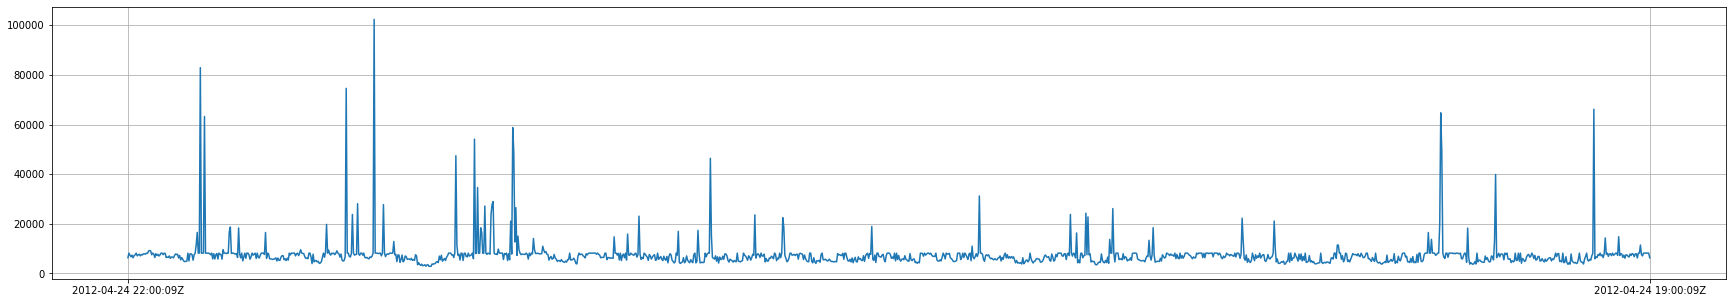

In [0]:
# max값 그래프

fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1,1,1)

x1 = datetime_list
y1 = max_list

# x축의 처음과 끝 값 성분만 나오도록 (간격 설정)

ax.set_xticks([0,len(y1)-1])

plt.plot(x1, y1)
plt.grid(True)
plt.show()

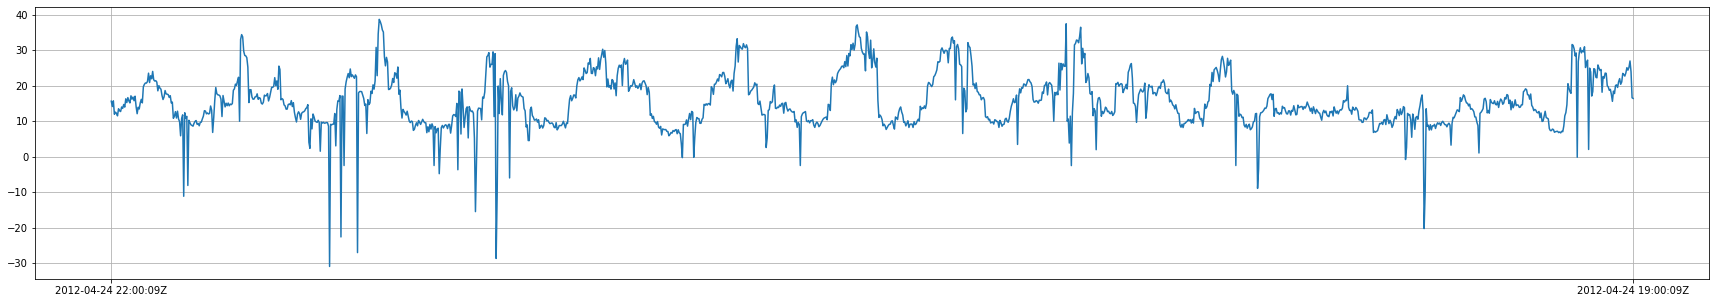

In [0]:
# min값 그래프

fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1,1,1)

x2 = datetime_list
y2 = min_list

ax.set_xticks([0,len(y2)-1])

plt.plot(x2, y2)
plt.grid(True)
plt.show()

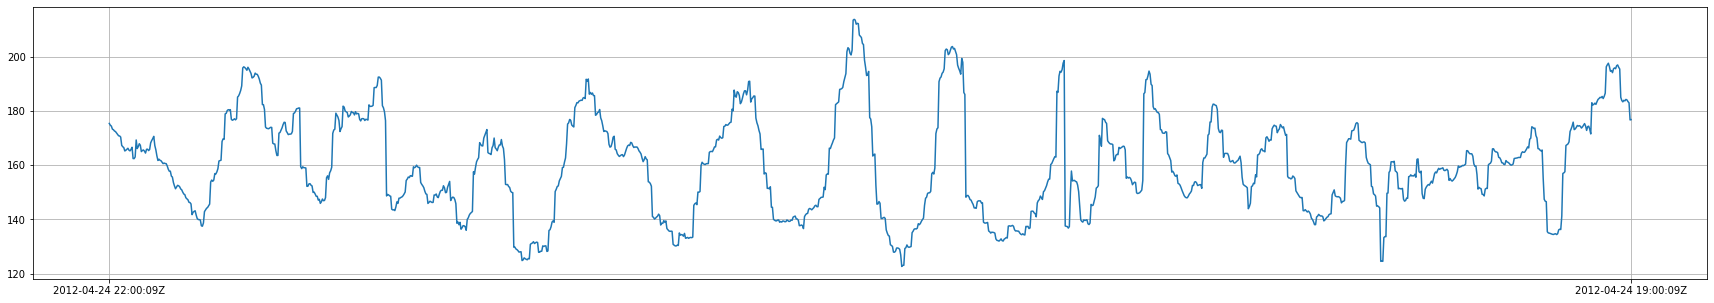

In [0]:
# median값 그래프

fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1,1,1)

x3 = datetime_list
y3 = median_list

ax.set_xticks([0,len(y3)-1])

plt.plot(x3, y3)
plt.grid(True)
plt.show()

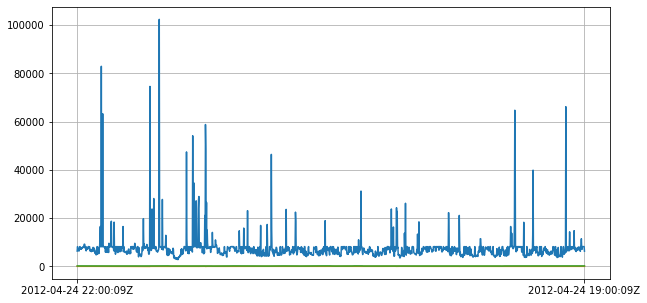

In [0]:
# 통합 버전

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

x = datetime_list

ax.set_xticks([0,len(y1)-1])

y1 = max_list
y2 = min_list
y3 = median_list

plt.grid()
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)

In [ ]:
# 2번 과정에서 굳이 새로 max, min_list 만들지 않기

print('20000이상 목록')

for i in range(0,len(file_list)):
    if max_list[i] >= 20000:
        print(file_list[i])
        
print('0이하 목록')

for i in range(0,len(file_list)):
    if min_list[i] <= 0:
        print(file_list[i])

In [0]:
# 2. AIA를 numpy array로 읽고, 노출 시간으로 나눠준 후, 태양 내부에만 해당하는 픽셀값 골라서, 그 중 min max만 구하기 (20000이상 or 0이하 값 골라내기 위해)

isize = 4096 # AIA 파일의 크기
X = np.arange(isize)[:, None]
Y = np.arange(isize)[None :]
XY = np.sqrt((X-isize/2.)**2. + (Y-isize/2.)**2.)

def run(i):
    file = fits.open(file_list[i]) # 메모리 문제 때문에 다시 닫기 위해서 close 기능 있는 astropy로 파일 읽기 (sunpy는 read)
    M = aiaprep(Map(file_list[i]))
    file.close()
    meta = M.meta
    rsun = meta['R_SUN'] # prep 했을 때 두 가지 rsun이 있는데, prep 안했을 때 rsun이 픽셀 단위이므로 prep 했을 때 rsun도 마찬가지임
    exptime = meta['EXPTIME']
    data = M.data / exptime
    Z = np.where(XY < rsun)
    aia_max = np.max(data[Z])
    aia_min = np.min(data[Z])

    return (aia_max, aia_min)

# 태양 내부 픽셀값들 중 max, min 값들을 모아놓은 리스트 만들기

max_list = []
min_list = []

for i in range(0,len(file_list)):
    max_list.append(run(i)[0])
    min_list.append(run(i)[1])

# AIA데이터의 max값 중 20000 이상과 min값 중 0 이하인 것은 수동으로 걸러내기 위해 해당 데이터 이름 출력

print('20000이상 목록')

for i in range(0,len(file_list)):
    if max_list[i] >= 20000:
        print(file_list[i])
        
print('0이하 목록')
        
for i in range(0,len(file_list)):
    if min_list[i] <= 0:
        print(file_list[i])

20000이상 목록
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-05-05-23-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-05-06-18-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-06-03-18-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-06-05-18-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-06-06-20-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-06-09-17-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-06-10-20-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-06-29-18-00-10.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-07-03-00-00-09.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-07-03-19-00-09.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-07-07-00-00-09.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-07-08-00-00-09.fits
/content/drive/My Drive/aia_2012_1hr_real//aia.193.2012-07-08-17-00-09.fits
/

In [0]:
# 3. AIA를 numpy array로 읽고, 노출 시간으로 나눠준 후, 그 중 rsun, data만 구해서 resize (He도 2번 과정까지 거친 다음에 실행해야함)

# AIA fits 파일 있는 폴더 경로 설정 (2번과 수동 과정을 통해 거를거 다 거르고 새로 업데이트 된)

file_list = os.listdir('/content/drive/My Drive/aia_2012_1hr_real')
file_list.sort()
file_list = ['/content/drive/My Drive/aia_2012_1hr_real//' + item for item in file_list]

isize = 4096 # AIA 파일의 크기
X = np.arange(isize)[:, None]
Y = np.arange(isize)[None :]
XY = np.sqrt((X-isize/2.)**2. + (Y-isize/2.)**2.)

def run(i):
    file = fits.open(file_list[i]) # 메모리 문제 때문에 다시 닫기 위해서 close 기능 있는 astropy로 파일 읽기 (sunpy는 read)
    M = aiaprep(Map(file_list[i]))
    file.close()
    meta = M.meta
    rsun = meta['R_SUN'] # prep 했을 때 두 가지 rsun이 있는데, prep 안했을 때 rsun이 픽셀 단위이므로 prep 했을 때 rsun도 마찬가지임
    exptime = meta['EXPTIME']
    data = M.data / exptime
    Z = np.where(XY < rsun)
    aia_median = np.median(data[Z])
    ratio = 10./aia_median
    
    # median 값을 임의의 값인 10으로 통일시켜서 degradation 보정 (=background의 밝기를 동일하게)
    
    data_new = data * ratio
    data_new = np.log10((data_new + 1.).clip(1., 100.)) * (255./2.)

    size = int(4096*412/rsun) # AIA 데이터에서 태양 반지름을 412픽셀로 바꿀 때 4096 이미지가 몇으로 줄어드는지의 정도
    re = resize(data_new,(size,size)) # resize 후의 data - 이때 태양 반지름 412 픽셀

    if size >= 1024: # 1024보다 크면 주변 잘라내기
        k = math.floor(re.shape[0]/2) # 중심 좌표 구하기
        new_re = re[k-512:k+512,k-512:k+512] # 중심 좌표로부터 좌우로 길이가 512인 정사각형 부분만 떼어내기
    else: # 1024보다 작으면 0 채워넣기
        if re.shape[0] % 2 == 0: # 짝수면 원래 상태에서 0 채우기
            new_re = np.pad(re, pad_width=(1024-re.shape[0])/2, mode='constant', constant_values=0)
        else: # 홀수면 가로세로 한 픽셀 줄씩 잘라내서 짝수로 만들고 0 채우기
            re = re[0:re.shape[0]-1,0:re.shape[0]-1]
            new_re = np.pad(re, pad_width=int((1024-re.shape[0])/2), mode='constant', constant_values=0)
    
    return new_re

# resize 시킨 데이터들을 새로운 리스트에 저장

print('Save AIA data in List')

new_re_list = []

for i in range(0,len(file_list)): # 첫째랑 마지막 데이터 어디서 어디로 끝나는지 알아서 넣기
    new_re_list.append(run(i))
    if i % 20 == 0:
        print(i) # 진행상황 보기

# resize된 AIA의 data 저장

print('Save AIA data')

for i in range(0,len(file_list)):
    np.save('/content/drive/My Drive/aia_2012_data/%s' % file_list[i][51:70], new_re_list[i])
    if i % 20 == 0:
        print(i) # 진행상황 보기

# 태양 반지름 412, 전체 이미지 1024, 1024로 resize 된 AIA 이미지 저장

path = os.listdir('/content/drive/My Drive/aia_2012_data')

print('Save AIA image')

def save_image_aia(i):
    file1 = np.load('/content/drive/My Drive/aia_2012_data/%s.npy' % file_list[i][51:70])
    imsave('/content/drive/My Drive/aia_2012_image/%s.png' % file_list[i][51:70], file.astype(np.uint8))

for i in range(0,len(file_list)):
    save_image_aia(i)
    if i % 20 == 0:
        print(i) # 진행상황 보기

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
